# LoGScale

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
def laplacian_g(x, y, sigma):
    x2 = x**2
    y2 = y**2
    sigma4 = sigma**4
    sigma2 = sigma**2

    # Returning the LoG filters' value in the pdf file
    return -1*(1/(np.pi*sigma4))*(1-((x2+y2)/(2*sigma2)))*np.exp(-1*(x2+y2)/(2*sigma2))

In [3]:
def filterImg(img, fil):
    fil = fil.astype('float')    
    img = img.astype('float')
    # this holds the end result
    filtered = np.zeros_like(img)
    width = int((fil.shape[1]-1)/2)
    height = int((fil.shape[0]-1)/2)
    # do the filtering
    for i in range(height,img.shape[1]-height):
        for j in range(width,img.shape[0]-width):
            filtered[j,i]= np.sum(fil * img[j-width:j+width+1, i-height:i+height+1])
    return filtered

In [4]:
def LoG(sigma=1.0, size=19):
    # Setting the range for LoG filter
    aran = np.arange(-1 * (size // 2), size // 2 + 1)
    XX, YY = np.meshgrid(aran, aran)
    # Calculating the LoG value an make an array
    kernel = laplacian_g(XX, YY, sigma)
    kernel = kernel * sigma**2 # normalization
    return kernel

In [5]:
for i in range(1,11):
    lap_g = LoG(i, 19)
    print(lap_g)

[[ 1.69077991e-34  7.42687699e-31  1.20195658e-27  7.18275049e-25
   1.58944656e-22  1.30695720e-20  4.00913904e-19  4.60662376e-18
   1.98992341e-17  3.23981869e-17  1.98992341e-17  4.60662376e-18
   4.00913904e-19  1.30695720e-20  1.58944656e-22  7.18275049e-25
   1.20195658e-27  7.42687699e-31  1.69077991e-34]
 [ 7.42687699e-31  3.21620583e-27  5.12277030e-24  3.00830671e-21
   6.53483971e-19  5.27394332e-17  1.58975387e-15  1.80032819e-14
   7.70176068e-14  1.24965002e-13  7.70176068e-14  1.80032819e-14
   1.58975387e-15  5.27394332e-17  6.53483971e-19  3.00830671e-21
   5.12277030e-24  3.21620583e-27  7.42687699e-31]
 [ 1.20195658e-27  5.12277030e-24  8.01053923e-21  4.60662376e-18
   9.77815231e-16  7.70176068e-14  2.26708698e-12  2.51528116e-11
   1.06096076e-10  1.71278631e-10  1.06096076e-10  2.51528116e-11
   2.26708698e-12  7.70176068e-14  9.77815231e-16  4.60662376e-18
   8.01053923e-21  5.12277030e-24  1.20195658e-27]
 [ 7.18275049e-25  3.00830671e-21  4.60662376e-18  2.58

In [6]:
def trackScale(img, sigmas, size, threshold):
    filters = []

    height, width = img.shape[:2]
    
    for s in sigmas:
        # making a list of filters with the given sigmas
        filters.append(LoG(s, size))
    # Make an holder for the images calculated with the filter
    images = np.zeros((height, width, len(filters)))


    for idx ,f in enumerate(filters):
        # Stack the images calculated
        images[:,:,idx] = np.square(filterImg(img, f))
    
    filMaxScale = np.zeros_like(img)
    maximum_scale = np.zeros_like(img)

    # Make an list for stack the value for (x,y,s)
    coord = []

    for h in range(height):
        for w in range(width):
            # fill the matrix with the max values of stacked images
            filMaxScale[h,w] = np.max(images[h,w,:])
            # fill the matrix with the scale value of stacked value
            maximum_scale[h,w] = sigmas[np.argmax(images[h,w,:])]

    
    print('='*20,"Calculating Local Maxima",'='*20)

    for h in range(1,height):
        for w in range(1,width):
            for s in range(1, len(sigmas)):
            # For calculating the local maximum the window is set to 3x3
                local_window = images[h-1:h+2, w-1:w+2,s-1:s+2]
                print(local_window.shape)
                maxima = np.amax(local_window)
                minima = np.amin(local_window)
                # Find the local maximum. If it's under the threshold then ignore it
                if local_window[1,1,1] == maxima:
                    peak = local_window[1,1,1]
                    if peak >= threshold:
                        # Get the value for (x,y,s) and store it in to the list 
                        z, x, y  = np.unravel_index(local_window.argmax(), local_window.shape)
                        coord.append((h+x-1, w+y-1, sigmas[z+1]))
                elif local_window[1,1,1] == minima:
                    peak = local_window[1,1,1]
                    if peak >= threshold:
                        # Get the value for (x,y,s) and store it in to the list 
                        z, x, y  = np.unravel_index(local_window.argmin(), local_window.shape)
                        coord.append((h+x-1, w+y-1, sigmas[z+1]))

    # Erase duplicated values
    coord = list(set(coord))
    
    print('='*20,"Plotting",'='*20)
    
    fig, ax = plt.subplots()

    ax.imshow(img,cmap="gray")
    
    # Plotting the circle
    for blob in coord:
        y,x,r = blob
        # The value for the rhadiian is scale multiplied with sqrt(2)
        c = plt.Circle((x, y), r*np.sqrt(2), linewidth=2 ,color='red', fill=False)
        ax.add_patch(c)
    ax.plot()  
    plt.show()

    return filMaxScale

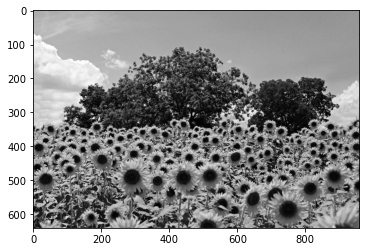

In [7]:
img = plt.imread('image3.png')
R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
img = 0.2989 * R + 0.5870 * G + 0.1140 * B
plt.imshow(img, cmap='gray')
plt.show()

In [8]:
# Setting the values for scale
sigmas = []
k = np.power(2, 1/3)
sigma = 1.6
for i  in range(7):
    sigmas.append(sigma*(k**i))

In [9]:
sigmas

[1.6,
 2.015873679831797,
 2.5398416831491195,
 3.2,
 4.031747359663594,
 5.079683366298239,
 6.400000000000002]

In [10]:
# It takes too much time
detected_img = trackScale(img, sigmas=sigmas, size=15, threshold=0.03)